In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
from datetime import timedelta
import os
from google.cloud import storage
import yfinance as yf

# Preprocessing Various Excel Files

## GDP
- By Quarter

In [3]:
import json
from urllib.request import Request,urlopen
hdr = {'User-Agent': 'Mozilla/5.0', "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,/;q=0.8"}
url = "https://tablebuilder.singstat.gov.sg/api/table/tabledata/M015651"
request = Request(url,headers=hdr)
gdp_data = urlopen(request).read()
print(gdp_data)

b'{"Data":{"theme":"Economy & Prices","subject":"National Accounts","topic":"Gross Domestic Product (GDP)","id":"M015651","title":"Gross Domestic Product At Current Prices, By Industry (SSIC 2020), Quarterly","footnote":"Data may not add up to the total due to rounding.  For more information on national accounts methodologies, please visit Singstat website (www.singstat.gov.sg/find-data/search-by-theme/economy/national-accounts/publications-and-methodology) to view and download related publications.","frequency":"Quarterly","datasource":"SINGAPORE DEPARTMENT OF STATISTICS","generatedBy":"SingStat Table Builder","dataLastUpdated":"12/08/2025","dateGenerated":"15/11/2025","offset":null,"limit":"5000","sortBy":null,"timeFilter":null,"between":null,"search":null,"row":[{"seriesNo":"1","rowText":"GDP At Current Market Prices","uoM":"Million Dollars","footnote":"","columns":[{"key":"1975 1Q","value":"3209.4"},{"key":"1975 2Q","value":"3307"},{"key":"1975 3Q","value":"3519.3"},{"key":"1975 4Q

In [4]:
json_data = json.loads(gdp_data)
# print(json)

selected = ['Manufacturing', 'Transportation & Storage', 
            'Finance & Insurance', 'Wholesale & Retail Trade']
rows = json_data['Data']['row']
print(rows)
# Step 2: Keep only selected GDP categories
filtered_rows = [r for r in rows if r['rowText'] in selected and r['seriesNo'][0] == '1']
# print(filtered_rows[4])
print(len(filtered_rows))
# Step 3: Build a tidy table
records = []

for r in filtered_rows:
    row_name = r['rowText']
    # Each quarter’s value is in 'columns'
    for c in r['columns']:
        quarter_label = c['key']       # e.g. '2025 2Q'
        value = c.get('value')
        records.append({'Quarter': quarter_label, 'Category': row_name, 'Value': value})

df = pd.DataFrame(records)
# Step 4: Convert 'Quarter' to datetime
df[['Year', 'Q']] = df['Quarter'].str.split(' ', expand=True)
df['Year'] = df['Year'].astype(int)
quarter_to_month = {'1Q': 3, '2Q': 6, '3Q': 9, '4Q': 12}
df['Month'] = df['Q'].map(quarter_to_month)
df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))

# Step 5: Pivot so each GDP category becomes a column
df_pivot = df.pivot(index='Date', columns='Category', values='Value').sort_index()

# Step 6: Convert to numeric (API data might be strings)
df_gdp = df_pivot.apply(pd.to_numeric, errors='coerce')

# ✅ Final GDP DataFrame
df_gdp

[{'seriesNo': '1', 'rowText': 'GDP At Current Market Prices', 'uoM': 'Million Dollars', 'footnote': '', 'columns': [{'key': '1975 1Q', 'value': '3209.4'}, {'key': '1975 2Q', 'value': '3307'}, {'key': '1975 3Q', 'value': '3519.3'}, {'key': '1975 4Q', 'value': '3693'}, {'key': '1976 1Q', 'value': '3545.1'}, {'key': '1976 2Q', 'value': '3620.2'}, {'key': '1976 3Q', 'value': '3846.5'}, {'key': '1976 4Q', 'value': '3991.6'}, {'key': '1977 1Q', 'value': '3873.5'}, {'key': '1977 2Q', 'value': '3963.1'}, {'key': '1977 3Q', 'value': '4172.4'}, {'key': '1977 4Q', 'value': '4344.2'}, {'key': '1978 1Q', 'value': '4284.1'}, {'key': '1978 2Q', 'value': '4376.8'}, {'key': '1978 3Q', 'value': '4695.8'}, {'key': '1978 4Q', 'value': '4980.7'}, {'key': '1979 1Q', 'value': '4768.5'}, {'key': '1979 2Q', 'value': '5061.6'}, {'key': '1979 3Q', 'value': '5461.2'}, {'key': '1979 4Q', 'value': '5849.9'}, {'key': '1980 1Q', 'value': '6017.1'}, {'key': '1980 2Q', 'value': '6246.6'}, {'key': '1980 3Q', 'value': '6

Category,Finance & Insurance,Manufacturing,Transportation & Storage,Wholesale & Retail Trade
Date,,,,
1975-03-01,248.9,654.9,291.2,672.8
1975-06-01,235.6,692.9,303.2,704.9
1975-09-01,242.0,785.1,331.6,716.0
1975-12-01,261.2,810.1,335.6,724.8
1976-03-01,270.3,744.8,364.0,677.5
...,...,...,...,...
2024-06-01,23957.2,29980.6,17728.3,39182.2
2024-09-01,24227.0,30780.6,16902.0,35717.5
2024-12-01,25548.5,28988.1,12726.6,40632.7


## Inflation

In [5]:
# hdr = {'User-Agent': 'Mozilla/5.0', "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,/;q=0.8"}
# url = "https://tablebuilder.singstat.gov.sg/api/table/tabledata/M213751?offset=20464"
# request = Request(url,headers=hdr)
# inflation_data = urlopen(request).read()
# print(inflation_data)

# json_data = json.loads(inflation_data)
# rows = json_data['Data']['row']
# print(rows[0])

In [6]:
# import pandas as pd

# selected = ['Motor Cars', 'Petrol', 'Other Fuel & Lubricants For Personal Transport Equipment']

# # Step 1: Filter rows for selected categories
# filtered_rows = [r for r in rows if r['rowText'] in selected]
# print(f"Number of filtered rows: {len(filtered_rows)}")

# # Step 2: Build a tidy table
# records = []
# for r in filtered_rows:
#     category = r['rowText']
#     for c in r['columns']:
#         date_label = c['key']   # e.g. '2025 09' or '2025 2Q'
#         value = c.get('value')
#         records.append({'DateLabel': date_label, 'Category': category, 'Value': value})

# df = pd.DataFrame(records)
# # print(df)
# # Step 3: Convert DateLabel to proper datetime
# # If your data is monthly like '2025 09'

# df['Date'] = pd.to_datetime(df['DateLabel'], format='%Y %b')


# # Step 4: Pivot so each category is a column
# df_pivot = df.pivot_table(index='Date', columns='Category', values='Value', aggfunc='first').sort_index()

# # Step 5: Convert to numeric
# df_inflation = df_pivot.apply(pd.to_numeric, errors='coerce')

# # ✅ Final monthly inflation DataFrame
# df_inflation.head()


## Yahoo Stock

In [7]:
# Get STI data
sti = yf.Ticker("^STI")

# Download historical data (e.g., past 5 years)
df_sti = sti.history(period="20y")

# Display the first few rows
df_sti.index  = pd.to_datetime(df_sti.index)

df_sti['Close_prev_day'] = df_sti['Close'].shift(1)
df_sti['Close_prev_2_days'] = df_sti['Close'].shift(2)
df_sti['Close_prev_3_days'] = df_sti['Close'].shift(3)

df_sti.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_prev_day,Close_prev_2_days,Close_prev_3_days
Date,,,,,,,,,,
2005-11-14 00:00:00+08:00,2272.610107,2272.610107,2248.280029,2254.149902,142399400,0.0,0.0,NaN,NaN,NaN
2005-11-15 00:00:00+08:00,2259.989990,2260.989990,2232.850098,2240.489990,159206600,0.0,0.0,2254.149902,NaN,NaN
2005-11-16 00:00:00+08:00,2243.919922,2255.120117,2241.340088,2254.459961,141767400,0.0,0.0,2240.489990,2254.149902,NaN
2005-11-17 00:00:00+08:00,2256.120117,2262.139893,2243.290039,2261.489990,136019600,0.0,0.0,2254.459961,2240.489990,2254.149902
2005-11-18 00:00:00+08:00,2270.739990,2293.199951,2269.629883,2293.199951,215749000,0.0,0.0,2261.489990,2254.459961,2240.489990


## COE (Target Variable)

In [8]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./car-resale-capstone-secret-key.json"

# Initialize the client (auth automatically detected from environment variable)
client = storage.Client()

# Name of your bucket
bucket_name = "car-resale-bucket"

# Path to the file in GCS
source_blob_name = "/datasets/coe.csv"

uri = f"gs://{bucket_name}/datasets/coe.csv"

df_coe = pd.read_csv(f"{uri}")
df_coe['Bidding_Date'] = pd.to_datetime(df_coe['Bidding_Date'])

df_coe['Bids_Success_Frac'] = df_coe['Bids_Success'] / df_coe['Bids_Received']
df_coe.head()

,Bidding_Date,Vehicle_Class,Quota,Bids_Success,Bids_Received,Premium,Bids_Success_Frac
0,2010-01-06,Category A,1152,1145,1342,18502,0.853204
1,2010-01-06,Category B,687,679,883,19190,0.768969
2,2010-01-06,Category C,173,173,265,19001,0.652830
3,2010-01-06,Category D,373,365,509,889,0.717092
4,2010-01-06,Category E,586,567,1011,19889,0.560831


In [9]:
# no missing premiums so create time plot by vehicle class
df_coe_a = df_coe[df_coe['Vehicle_Class'] == 'Category A']
df_coe_b = df_coe[df_coe['Vehicle_Class'] == 'Category B']

df_coe_a = df_coe_a.drop(columns=['Vehicle_Class'])
df_coe_b = df_coe_b.drop(columns=['Vehicle_Class'])
# For df_coe_a
df_coe_a_copy = df_coe_a.copy()
df_coe_a_copy = df_coe_a_copy.apply(pd.to_numeric, errors='coerce')  # force numeric, non-numeric -> NaN
# df_coe_a_copy = df_coe_a_copy.pct_change().dropna()

# For df_coe_b
df_coe_b_copy = df_coe_b.copy()
df_coe_b_copy = df_coe_b_copy.apply(pd.to_numeric, errors='coerce')
# df_coe_b_copy = df_coe_b_copy.pct_change().dropna()
# df_coe_a

# For df_inflation
# df_inflation_copy = df_inflation.copy()
# df_inflation_copy = df_inflation_copy.apply(pd.to_numeric, errors='coerce')  # force numeric
# df_inflation_copy = df_inflation_copy.pct_change().dropna()

# For df_gdp
df_gdp_copy = df_gdp.copy()
df_gdp_copy = df_gdp_copy.apply(pd.to_numeric, errors='coerce')  # force numeric
# df_gdp_copy = df_gdp_copy.pct_change().dropna()

In [10]:
import pandas as pd

# --- 1. Prepare all dataframes at once ---
# Reset, rename, and convert date types for all source tables

# COE A
df_coe_a_reset = df_coe_a_copy.reset_index().rename(columns={'Bidding_Date': 'date'})
df_coe_a_reset['date'] = pd.to_datetime(df_coe_a_reset['date'])

# COE B
df_coe_b_reset = df_coe_b_copy.reset_index().rename(columns={'Bidding_Date': 'date'})
df_coe_b_reset['date'] = pd.to_datetime(df_coe_b_reset['date'])


# GDP (Sort once, use for both merges)
df_gdp_sorted = df_gdp_copy.reset_index().rename(columns={'Date': 'date'})
df_gdp_sorted['date'] = pd.to_datetime(df_gdp_sorted['date'])
df_gdp_sorted = df_gdp_sorted.sort_values('date')


df_merged_a = pd.merge_asof(
    df_coe_a_reset.sort_values('date'),
    df_gdp_sorted,
    on='date',
    direction='backward'
)
# Drop NaNs that result from dates at the end of the series
df_coe_with_gdp_a = df_merged_a.set_index('date')

df_merged_b = pd.merge_asof(
    df_coe_b_reset.sort_values('date'), # No need to re-sort
    df_gdp_sorted,
    on='date',
    direction='backward'
)
# Drop NaNs that result from dates at the beginning of the series
df_coe_with_gdp_b = df_merged_b.set_index('date')

In [11]:
# Ensure both are datetime64[ns] and timezone-naive
# df_sti['Date'] = df_sti.index
df_sti = df_sti.reset_index()
# Convert df_sti['Date'] to datetime without timezone
df_sti['Date'] = pd.to_datetime(df_sti['Date']).dt.tz_localize(None)

# Convert df_coe_with_gdp_a['date'] to datetime64[ns] (not .dt.date)
df_coe_with_gdp_a = df_coe_with_gdp_a.reset_index() 
df_coe_with_gdp_a['date'] = pd.to_datetime(df_coe_with_gdp_a['date'])

# df_coe_with_gdp_a
# Now merge
df_merged_a = pd.merge_asof(
    df_coe_with_gdp_a.sort_values('date'),
    df_sti[['Date', 'Close_prev_day']].sort_values('Date'),
    left_on='date',
    right_on='Date',
    direction='backward',       # can be 'backward', 'forward', or 'nearest'
    tolerance=pd.Timedelta('7D')  # optional: only match if within 7 days
)

# df_merged_a[df_merged_a['Close_prev_day'].isna()]
# df_merged_a['Close_prev_day'] = df_merged_a['Close_prev_day'].fillna(df_merged_a['Close_prev_3_days'])

df_merged_a = df_merged_a.drop(columns=['Date', 'index'])

In [12]:
# Convert df_coe_with_gdp_a['date'] to datetime64[ns] (not .dt.date)
df_coe_with_gdp_b = df_coe_with_gdp_b.reset_index() 
df_coe_with_gdp_b['date'] = pd.to_datetime(df_coe_with_gdp_b['date'])

# Now merge
df_merged_b = pd.merge_asof(
    df_coe_with_gdp_b.sort_values('date'),
    df_sti[['Date', 'Close_prev_day']].sort_values('Date'),
    left_on='date',
    right_on='Date',
    direction='backward',       # can be 'backward', 'forward', or 'nearest'
    tolerance=pd.Timedelta('7D')  # optional: only match if within 7 days
)

df_merged_b = df_merged_b.drop(columns=['Date', 'index'])

In [13]:
df_merged_a.isna().sum()

date                        0
Quota                       0
Bids_Success                0
Bids_Received               0
Premium                     0
Bids_Success_Frac           0
Finance & Insurance         0
Manufacturing               0
Transportation & Storage    0
Wholesale & Retail Trade    0
Close_prev_day              0
dtype: int64

# Feature Engineering

In [14]:
# all columns need to lag except date and premium because premium is the target and date is the index
columns_lag_1 = ['Quota', 'Bids_Success', 'Bids_Received', 'Bids_Success_Frac']

columns_lag_2 = ['Motor Cars', 'Other Fuel & Lubricants For Personal Transport Equipment', 'Petrol']

columns_lag_3 = ['Finance & Insurance', 'Manufacturing', 'Transportation & Storage', 'Wholesale & Retail Trade']

# Create lagged features
df_merged_a_lag = df_merged_a.copy()
df_merged_b_lag = df_merged_b.copy()

# --- Lag 1 ---
for col in columns_lag_1:
    df_merged_a_lag[f'{col}_lag1'] = df_merged_a_lag[col].shift(1)
    df_merged_b_lag[f'{col}_lag1'] = df_merged_b_lag[col].shift(1)

# --- Lag 2 ---
# for col in columns_lag_2:
#     df_merged_a_lag[f'{col}_lag2'] = df_merged_a_lag[col].shift(2)
#     df_merged_b_lag[f'{col}_lag2'] = df_merged_b_lag[col].shift(2)

# --- Lag 3 ---
for col in columns_lag_3:
    df_merged_a_lag[f'{col}_lag3'] = df_merged_a_lag[col].shift(3)
    df_merged_b_lag[f'{col}_lag3'] = df_merged_b_lag[col].shift(3)

In [15]:
lagged_column_names = [col for col in df_merged_a_lag.columns if 'lag' in col]
relevant_features = lagged_column_names + ['date', 'Premium', 'Close_prev_day']

X_features = lagged_column_names + ['Close_prev_day', 'date']
y_features = ['Premium']

# Copy base data
df_diff_a = df_merged_a_lag.copy()
df_diff_b = df_merged_b_lag.copy()

# Exclude 'date' when computing differences
X_features_to_diff = [col for col in X_features if col != 'date']

# ---------- Create all difference features efficiently ----------
def create_diff_features(df, feature_list):
    diff_frames = []
    for lag in range(1, 13):
        diff_df = df[feature_list].apply(lambda x: x - x.shift(lag))
        diff_df.columns = [f'{col}_diff_{lag}' for col in feature_list]
        diff_frames.append(diff_df)
    # Concatenate all lags horizontally
    diff_all = pd.concat(diff_frames, axis=1)
    return pd.concat([df, diff_all], axis=1)

# Apply to both datasets
df_diff_a = create_diff_features(df_diff_a, X_features_to_diff)
df_diff_b = create_diff_features(df_diff_b, X_features_to_diff)

# Create 1-step difference for target
df_diff_a['Premium_diff_1'] = df_diff_a['Premium'] - df_diff_a['Premium'].shift(1)
df_diff_b['Premium_diff_1'] = df_diff_b['Premium'] - df_diff_b['Premium'].shift(1)

# Define final feature sets
final_X = [f'{col}_diff_{lag}' for col in X_features_to_diff for lag in range(1, 13)]
final_y = ['Premium_diff_1']

In [16]:
df_diff_a[df_diff_a['date'] >= '2023-01-01']

,date,Quota,Bids_Success,Bids_Received,Premium,Bids_Success_Frac,Finance & Insurance,Manufacturing,Transportation & Storage,Wholesale & Retail Trade,...,Quota_lag1_diff_12,Bids_Success_lag1_diff_12,Bids_Received_lag1_diff_12,Bids_Success_Frac_lag1_diff_12,Finance & Insurance_lag3_diff_12,Manufacturing_lag3_diff_12,Transportation & Storage_lag3_diff_12,Wholesale & Retail Trade_lag3_diff_12,Close_prev_day_diff_12,Premium_diff_1
306,2023-01-04,462,459,649,80000,0.707242,21571.8,30053.8,16981.7,38540.8,...,-141.0,-126.0,-232.0,0.060225,1247.9,-896.8,509.4,7788.0,141.689941,-8007.0
307,2023-01-18,459,456,627,86000,0.727273,21571.8,30053.8,16981.7,38540.8,...,-155.0,-147.0,-251.0,0.033909,1620.2,-7867.1,-5566.3,-3281.2,162.719971,6000.0
308,2023-02-08,509,497,663,86000,0.749623,21571.8,30053.8,16981.7,38540.8,...,-169.0,-164.0,-207.0,-0.016133,1620.2,-7867.1,-5566.3,-3281.2,141.690186,0.0
309,2023-02-22,508,504,702,86556,0.717949,21571.8,30053.8,16981.7,38540.8,...,-45.0,-44.0,-26.0,-0.035573,1620.2,-7867.1,-5566.3,-3281.2,53.070068,556.0
310,2023-03-08,517,507,665,88000,0.762406,23669.3,29781.5,14967.5,29377.0,...,-43.0,-47.0,-133.0,0.058068,1620.2,-7867.1,-5566.3,-3281.2,21.090088,1444.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,2025-09-03,1275,1271,1844,107889,0.689262,25216.7,32020.1,15488.7,37669.6,...,115.0,108.0,-368.0,0.152260,-331.8,3032.0,2762.1,-2963.1,407.749756,3365.0
371,2025-09-17,1272,1266,2521,119003,0.502182,25216.7,32020.1,15488.7,37669.6,...,131.0,127.0,-190.0,0.126824,-331.8,3032.0,2762.1,-2963.1,442.770264,11114.0
372,2025-10-08,1268,1239,2572,128105,0.481726,25216.7,32020.1,15488.7,37669.6,...,134.0,129.0,570.0,-0.080596,-331.8,3032.0,2762.1,-2963.1,1002.789795,9102.0
373,2025-10-22,1270,1262,1968,122000,0.641260,25216.7,32020.1,15488.7,37669.6,...,130.0,117.0,410.0,-0.037238,-1582.5,-20.0,-717.3,3856.5,585.639893,-6105.0


In [17]:
import numpy as np

def fourier_features(df, period, order):
    """
    Create Fourier series terms for a given period and order.
    - df: DataFrame containing your time index
    - time_col: column name containing timestamps or integer index
    - period: number of observations per cycle (e.g., 12 for monthly data with yearly seasonality)
    - order: number of sine/cosine pairs
    """
    t = np.arange(len(df))
    X = pd.DataFrame(index=df.index)
    for k in range(1, order + 1):
        X[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        X[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return X

df_fourier = fourier_features(df_diff_a, 240, 1)

df_diff_with_fourier_a = pd.concat([df_diff_a, df_fourier], axis=1)
df_diff_with_fourier_b = pd.concat([df_diff_b, df_fourier], axis=1)

In [18]:
final_X.extend(df_fourier.columns)

In [19]:
start_val_date='2022-08-18'
end_val_date='2024-05-08'

In [42]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

def forward_select_arimax(df, final_X, final_y, start_val_date='2022-08-18', end_val_date='2024-05-08', d=1, order=(0,1,0)):
    """
    Forward selection for ARIMAX with rolling validation.
    Greedily adds features or increases p/q based on lowest validation MAE.

    Parameters
    ----------
    df : pd.DataFrame
        Dataset with datetime index and all candidate features.
    final_X : list
        List of candidate exogenous variable names.
    final_y : list
        List with one target variable name.
    train_years : int
        Number of years for training (default=12).
    val_years : int
        Number of years for validation (default=2).
    d : int
        Differencing order (fixed to 1 by default).
    max_p : int
        Maximum AR order to explore.
    max_q : int
        Maximum MA order to explore.

    Returns
    -------
    dict : {
        'selected_features': list,
        'best_order': (p,d,q),
        'best_mae': float
    }
    """

    # --- ensure sorted by time ---
    df = df.copy().sort_index()
    y_col = final_y[0]

    # --- split train/validation based on years ---
    total_years = df.index[-1].year - df.index[0].year + 1
    
    cutoff_train = start_val_date
    cutoff_val = end_val_date

 
    df_train = df[df.index < cutoff_train]
    df_val = df[(df.index >= cutoff_train) & (df.index <= cutoff_val)]

    # --- print training date range ---
    print(f"Training date range: {df_train.index.min().date()} → {df_train.index.max().date()}, {len(df_train)} records")
    print(f"Validation date range: {df_val.index.min().date()} → {df_val.index.max().date()}, {len(df_val)} records")
    # --- initialize parameters ---
    selected_features = []

    
    best_order = order

    mae, _, _, _ = rolling_validation_arimax_multihorizon(df_train, df_val, y_col, [], best_order)
    best_mae = sum(mae.values()) / len(mae)
    print(f"Initial MAE with no exogenous variables and order {best_order}: {best_mae:.4f}")
    remaining_features = list(final_X)

    improved = True
    iteration = 0

    while improved and remaining_features:
        iteration += 1
        print(f"\n=== Iteration {iteration} ===")
        candidates = []

        # 1️⃣ Try adding one new exogenous variable
        pbar = tqdm(remaining_features, desc="Evaluating candidate features")
        for feature in pbar:
            candidate_features = selected_features + [feature]
            mae, aligned_preds_df, actual_vals, val_dates = rolling_validation_arimax_multihorizon(df_train, df_val, y_col, candidate_features, best_order)

            mean_mae = sum(mae.values()) / len(mae)
            # print(mean_mae)
            pbar.set_postfix({
                "Feature": feature,
                "MAE": f"{mean_mae:.4f}"
            })
            candidates.append({
                'type': 'feature',
                'change': feature,
                'order': best_order,
                'mae': mean_mae
            })
        # print(candidates)

        # --- pick best candidate ---
        best_candidate = min(candidates, key=lambda x: x['mae'])
        print(f"Best candidate: {best_candidate}")

        if best_candidate['mae'] < best_mae:
            best_mae = best_candidate['mae']
            if best_candidate['type'] == 'feature':
                selected_features.append(best_candidate['change'])
                remaining_features.remove(best_candidate['change'])
            else:
                best_order = best_candidate['order']
        else:
            improved = False

    print("\n=== Final Selection ===")
    print(f"Features: {selected_features}")
    print(f"Order: {best_order}")
    print(f"Validation MAE: {best_mae:.4f}")

   

    return {
        'selected_features': selected_features,
        'best_order': best_order,
        'best_mae': best_mae
    }, df_train, df_val


def rolling_validation_arimax_multihorizon(df_train, df_val, y_col, exog_cols=None, order=(1,0,0), max_horizon=4, summary=False):
    """
    Rolling-origin multi-horizon validation for ARIMAX with horizon-aligned MAE.
    Returns MAE per horizon, aligned predictions, actuals, and validation dates.
    """

    # Concatenate train + validation
    full_df = pd.concat([df_train, df_val])
    val_idx_start = len(df_train)
    val_len = len(df_val)
    full_len = len(full_df)
    val_dates = full_df.index[val_idx_start : val_idx_start + val_len]

    # Prepare storage for aligned predictions
    horizons = list(range(1, max_horizon + 1))
    aligned_preds = pd.DataFrame(
        np.nan,
        index=full_df.index,
        columns=[f"h{h}" for h in horizons]
    )

    # Rolling forecast loop
    for t in range(val_idx_start, full_len - max_horizon):
        train_data = full_df.iloc[:t]
        test_exog = None

        if exog_cols:
            test_exog = full_df[exog_cols].iloc[t : t + max_horizon]

        try:
            model = SARIMAX(
                train_data[y_col],
                exog=train_data[exog_cols] if exog_cols else None,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            fc = model.forecast(
                steps=max_horizon,
                exog=test_exog
            )

            # Align forecasts: t predicts (t+1 ... t+H)
            for h in horizons:
                future_idx = t + h
                if future_idx < full_len:
                    aligned_preds.iloc[future_idx, h - 1] = fc.iloc[h - 1]

        except Exception:
            # Leave NaNs for this step
            continue

    # Extract actual validation values
    actual_vals = full_df[y_col].iloc[val_idx_start : val_idx_start + val_len]

    # Compute horizon-aligned MAE
    mae_dict = {}
    for h in horizons:
        col = f"h{h}"
        preds_slice = aligned_preds[col].iloc[val_idx_start : val_idx_start + val_len]
        actual_slice = actual_vals

        valid_mask = ~preds_slice.isna()
        preds_valid = preds_slice[valid_mask]
        actual_valid = actual_slice[valid_mask]

        if len(preds_valid) > 0:
            mae_dict[col] = mean_absolute_error(actual_valid, preds_valid)
        else:
            mae_dict[col] = np.nan

    # Only keep validation slice of aligned predictions
    aligned_preds_df = aligned_preds.iloc[val_idx_start : val_idx_start + val_len]

    if summary:
        print(model.summary())

    return mae_dict, aligned_preds_df, actual_vals, val_dates

In [27]:
df_diff_with_fourier_final_a = df_diff_with_fourier_a.dropna()
df_diff_with_fourier_final_b = df_diff_with_fourier_b.dropna()

In [28]:
df_diff_with_fourier_final_a['date'] = pd.to_datetime(df_diff_with_fourier_final_a['date'])
df_diff_with_fourier_final_a.index = df_diff_with_fourier_final_a['date']
df_diff_with_fourier_final_a = df_diff_with_fourier_final_a.drop(['date'],axis=1)

df_diff_with_fourier_final_b['date'] = pd.to_datetime(df_diff_with_fourier_final_b['date'])
df_diff_with_fourier_final_b.index = df_diff_with_fourier_final_b['date']
df_diff_with_fourier_final_b = df_diff_with_fourier_final_b.drop(['date'],axis=1)

In [29]:
def select_top_k_features(df, final_X, final_y, k=10):
    """
    Select the top k features most correlated with the target.
    
    Parameters
    ----------
    df : pd.DataFrame
    final_X : list
        Candidate feature names
    final_y : list of length 1
        Target variable name
    k : int
        Number of top features to select
    
    Returns
    -------
    top_k_features : list
        List of top k feature names
    """
    y_col = final_y[0]
    # Compute absolute correlation
    corr = df[final_X + [y_col]].corr()[y_col].abs().drop(y_col)
    # Sort descending and select top k
    top_k_features = corr.sort_values(ascending=False).head(k).index.tolist()
    return top_k_features

filter_a = select_top_k_features(df_diff_with_fourier_final_a, final_X, final_y, 25)
filter_b = select_top_k_features(df_diff_with_fourier_final_b, final_X, final_y, 25)
# filter_a.append('cos_1')


In [30]:
import warnings

warnings.filterwarnings('ignore')

In [31]:
results_a, df_train_a, df_val_a = forward_select_arimax(df_diff_with_fourier_final_a, filter_a, ['Premium'], order=(4,1,5))
results_a

Training date range: 2010-08-18 → 2022-08-17, 283 records
Validation date range: 2022-09-07 → 2024-05-08, 41 records
Initial MAE with no exogenous variables and order (4, 1, 5): 7594.7049

=== Iteration 1 ===


Evaluating candidate features: 100%|██████████| 25/25 [07:12<00:00, 17.30s/it, Feature=Bids_Success_Frac_lag1_diff_9, MAE=7577.9312]        


Best candidate: {'type': 'feature', 'change': 'Wholesale & Retail Trade_lag3_diff_12', 'order': (4, 1, 5), 'mae': 7400.241362330018}

=== Iteration 2 ===


Evaluating candidate features: 100%|██████████| 24/24 [09:01<00:00, 22.57s/it, Feature=Bids_Success_Frac_lag1_diff_9, MAE=7440.8662]        


Best candidate: {'type': 'feature', 'change': 'Wholesale & Retail Trade_lag3_diff_8', 'order': (4, 1, 5), 'mae': 7260.229529934342}

=== Iteration 3 ===


Evaluating candidate features: 100%|██████████| 23/23 [10:48<00:00, 28.20s/it, Feature=Bids_Success_Frac_lag1_diff_9, MAE=7385.4714]        


Best candidate: {'type': 'feature', 'change': 'Bids_Received_lag1_diff_9', 'order': (4, 1, 5), 'mae': 7211.425464493761}

=== Iteration 4 ===


Evaluating candidate features: 100%|██████████| 22/22 [12:47<00:00, 34.89s/it, Feature=Bids_Success_Frac_lag1_diff_9, MAE=7334.7620]        


Best candidate: {'type': 'feature', 'change': 'Transportation & Storage_lag3_diff_11', 'order': (4, 1, 5), 'mae': 7179.961818828669}

=== Iteration 5 ===


Evaluating candidate features: 100%|██████████| 21/21 [11:56<00:00, 34.10s/it, Feature=Bids_Success_Frac_lag1_diff_9, MAE=7309.1298]        


Best candidate: {'type': 'feature', 'change': 'Transportation & Storage_lag3_diff_12', 'order': (4, 1, 5), 'mae': 7126.137300311113}

=== Iteration 6 ===


Evaluating candidate features: 100%|██████████| 20/20 [11:48<00:00, 35.43s/it, Feature=Bids_Success_Frac_lag1_diff_9, MAE=7349.3725]       

Best candidate: {'type': 'feature', 'change': 'Manufacturing_lag3_diff_5', 'order': (4, 1, 5), 'mae': 7130.413565503195}

=== Final Selection ===
Features: ['Wholesale & Retail Trade_lag3_diff_12', 'Wholesale & Retail Trade_lag3_diff_8', 'Bids_Received_lag1_diff_9', 'Transportation & Storage_lag3_diff_11', 'Transportation & Storage_lag3_diff_12']
Order: (4, 1, 5)
Validation MAE: 7126.1373


{'selected_features': ['Wholesale & Retail Trade_lag3_diff_12',
  'Wholesale & Retail Trade_lag3_diff_8',
  'Bids_Received_lag1_diff_9',
  'Transportation & Storage_lag3_diff_11',
  'Transportation & Storage_lag3_diff_12'],
 'best_order': (4, 1, 5),
 'best_mae': 7126.137300311113}

In [38]:
import matplotlib.pyplot as plt

def plot_aligned_forecasts(
    aligned_preds,
    actual_vals,
    val_idx_start,
    val_len,
    horizons,
    title="Aligned Multi-Horizon Forecasts"
):
    """
    aligned_preds: DataFrame where each column is h1, h2, ..., hK
    actual_vals:   Series of true values (full timeline)
    val_idx_start: index where validation period starts
    val_len:       number of points in validation period
    horizons:      list of horizon integers, e.g. [1,2,3,6,12]
    """

    fig, ax = plt.subplots(figsize=(16, 6))

    # ---- Plot true values ----
    ax.plot(actual_vals.index, actual_vals.values, label="Actual", linewidth=2)

    # ---- Plot each horizon ----
    for h in horizons:
        col = f"h{h}"

        ax.plot(
            aligned_preds.index,
            aligned_preds[col],
            label=col,
            alpha=0.7
        )

    # ---- Highlight validation region ----
    val_start = aligned_preds.index[val_idx_start]
    val_end = aligned_preds.index[val_idx_start + val_len - 1]

    ax.axvspan(val_start, val_end, color="grey", alpha=0.15, label="Validation Window")

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("COE Price")
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

                               SARIMAX Results                                
Dep. Variable:                Premium   No. Observations:                  319
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -2996.323
Date:                Sat, 15 Nov 2025   AIC                           6022.647
Time:                        10:17:12   BIC                           6078.792
Sample:                             0   HQIC                          6045.086
                                - 319                                         
Covariance Type:                  opg                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Wholesale & Retail Trade_lag3_diff_12    -0.5961      0.180     -3.305      0.001      -0.950      -0.243
Wholesale & Retail Trade_lag3_diff_8      0.4257  

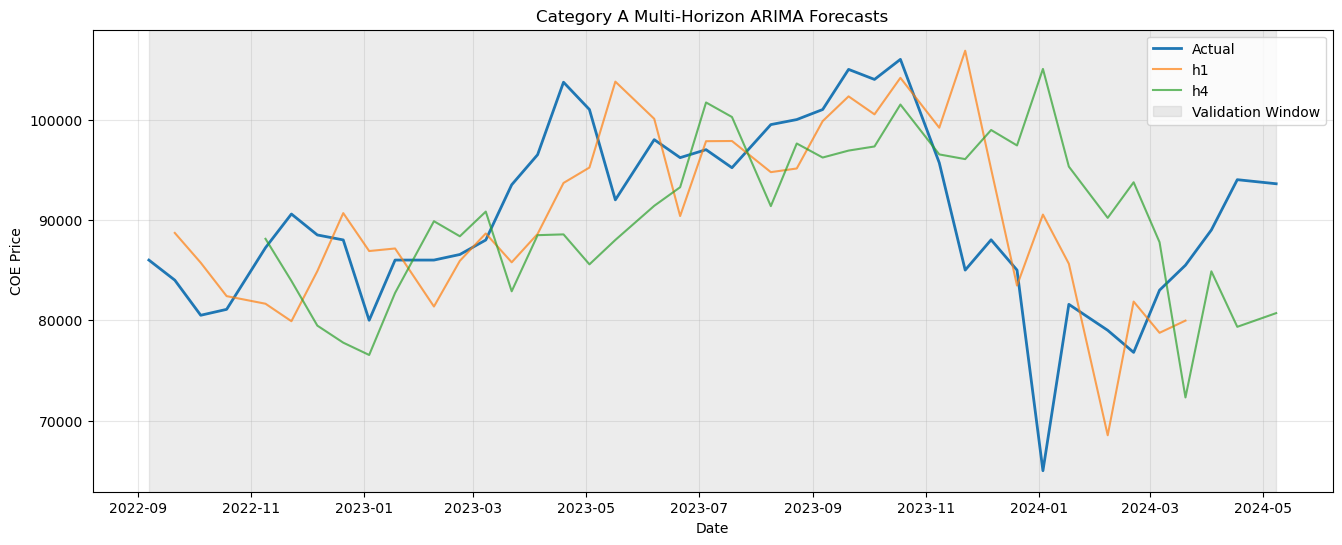

In [43]:
mae_a, aligned_preds_df_a, actual_vals_a, val_dates_a =  rolling_validation_arimax_multihorizon(df_train_a, df_val_a, 'Premium', exog_cols=results_a['selected_features'], order=(4,1,5), max_horizon=4, summary=True)

plot_aligned_forecasts(
    aligned_preds_df_a,
    actual_vals_a,
    0,
    len(actual_vals_a),
    horizons=[1, 4],
    title="Category A Multi-Horizon ARIMA Forecasts"
)

In [34]:
results_b, df_train_b, df_val_b = forward_select_arimax(df_diff_with_fourier_final_b, filter_b, ['Premium'], order=(0,1,5))

Training date range: 2010-08-18 → 2022-08-17, 283 records
Validation date range: 2022-09-07 → 2024-05-08, 41 records
Initial MAE with no exogenous variables and order (0, 1, 5): 10770.9082

=== Iteration 1 ===


Evaluating candidate features: 100%|██████████| 25/25 [01:51<00:00,  4.44s/it, Feature=cos_1, MAE=10818.9295]                                


Best candidate: {'type': 'feature', 'change': 'Bids_Success_Frac_lag1_diff_12', 'order': (0, 1, 5), 'mae': 10441.12686835811}

=== Iteration 2 ===


Evaluating candidate features: 100%|██████████| 24/24 [02:00<00:00,  5.03s/it, Feature=cos_1, MAE=10499.2168]                                


Best candidate: {'type': 'feature', 'change': 'Bids_Success_Frac_lag1_diff_2', 'order': (0, 1, 5), 'mae': 10394.96354591348}

=== Iteration 3 ===


Evaluating candidate features: 100%|██████████| 23/23 [02:17<00:00,  5.98s/it, Feature=cos_1, MAE=10437.8686]                                


Best candidate: {'type': 'feature', 'change': 'Bids_Success_Frac_lag1_diff_4', 'order': (0, 1, 5), 'mae': 10354.439591714123}

=== Iteration 4 ===


Evaluating candidate features: 100%|██████████| 22/22 [02:23<00:00,  6.52s/it, Feature=cos_1, MAE=10342.1434]                                


Best candidate: {'type': 'feature', 'change': 'Bids_Received_lag1_diff_2', 'order': (0, 1, 5), 'mae': 10321.725836033027}

=== Iteration 5 ===


Evaluating candidate features: 100%|██████████| 21/21 [03:47<00:00, 10.82s/it, Feature=cos_1, MAE=10311.0114]                                


Best candidate: {'type': 'feature', 'change': 'Bids_Success_lag1_diff_2', 'order': (0, 1, 5), 'mae': 10287.126427028968}

=== Iteration 6 ===


Evaluating candidate features: 100%|██████████| 20/20 [04:12<00:00, 12.60s/it, Feature=cos_1, MAE=10270.9911]                                


Best candidate: {'type': 'feature', 'change': 'Finance & Insurance_lag3_diff_1', 'order': (0, 1, 5), 'mae': 10257.535592672262}

=== Iteration 7 ===


Evaluating candidate features: 100%|██████████| 19/19 [07:03<00:00, 22.31s/it, Feature=cos_1, MAE=10317.9399]                                


Best candidate: {'type': 'feature', 'change': 'Finance & Insurance_lag3_diff_6', 'order': (0, 1, 5), 'mae': 10240.393331724303}

=== Iteration 8 ===


Evaluating candidate features: 100%|██████████| 18/18 [07:52<00:00, 26.22s/it, Feature=cos_1, MAE=10248.9732]                                


Best candidate: {'type': 'feature', 'change': 'sin_1', 'order': (0, 1, 5), 'mae': 10231.229175630237}

=== Iteration 9 ===


Evaluating candidate features: 100%|██████████| 17/17 [08:10<00:00, 28.87s/it, Feature=cos_1, MAE=10090.9423]                                


Best candidate: {'type': 'feature', 'change': 'cos_1', 'order': (0, 1, 5), 'mae': 10090.942269851064}

=== Iteration 10 ===


Evaluating candidate features: 100%|██████████| 16/16 [07:39<00:00, 28.69s/it, Feature=Transportation & Storage_lag3_diff_11, MAE=10157.7658]


Best candidate: {'type': 'feature', 'change': 'Bids_Success_Frac_lag1_diff_1', 'order': (0, 1, 5), 'mae': 10073.668683218715}

=== Iteration 11 ===


Evaluating candidate features: 100%|██████████| 15/15 [08:26<00:00, 33.77s/it, Feature=Transportation & Storage_lag3_diff_11, MAE=10147.0068]


Best candidate: {'type': 'feature', 'change': 'Bids_Received_lag1_diff_1', 'order': (0, 1, 5), 'mae': 10027.876099551566}

=== Iteration 12 ===


Evaluating candidate features: 100%|██████████| 14/14 [07:20<00:00, 31.45s/it, Feature=Transportation & Storage_lag3_diff_11, MAE=10081.9615]


Best candidate: {'type': 'feature', 'change': 'Wholesale & Retail Trade_lag3_diff_5', 'order': (0, 1, 5), 'mae': 10003.145994684259}

=== Iteration 13 ===


Evaluating candidate features: 100%|██████████| 13/13 [07:57<00:00, 36.75s/it, Feature=Transportation & Storage_lag3_diff_11, MAE=10023.0907]


Best candidate: {'type': 'feature', 'change': 'Quota_lag1_diff_1', 'order': (0, 1, 5), 'mae': 9998.289506137096}

=== Iteration 14 ===


Evaluating candidate features: 100%|██████████| 12/12 [07:24<00:00, 37.01s/it, Feature=Transportation & Storage_lag3_diff_11, MAE=10019.0858]


Best candidate: {'type': 'feature', 'change': 'Manufacturing_lag3_diff_1', 'order': (0, 1, 5), 'mae': 9995.8267688168}

=== Iteration 15 ===


Evaluating candidate features: 100%|██████████| 11/11 [07:12<00:00, 39.35s/it, Feature=Transportation & Storage_lag3_diff_11, MAE=10026.4929]


Best candidate: {'type': 'feature', 'change': 'Close_prev_day_diff_2', 'order': (0, 1, 5), 'mae': 9981.206378821924}

=== Iteration 16 ===


Evaluating candidate features: 100%|██████████| 10/10 [07:13<00:00, 43.34s/it, Feature=Transportation & Storage_lag3_diff_11, MAE=10053.0855]

Best candidate: {'type': 'feature', 'change': 'Quota_lag1_diff_2', 'order': (0, 1, 5), 'mae': 9991.663638524933}

=== Final Selection ===
Features: ['Bids_Success_Frac_lag1_diff_12', 'Bids_Success_Frac_lag1_diff_2', 'Bids_Success_Frac_lag1_diff_4', 'Bids_Received_lag1_diff_2', 'Bids_Success_lag1_diff_2', 'Finance & Insurance_lag3_diff_1', 'Finance & Insurance_lag3_diff_6', 'sin_1', 'cos_1', 'Bids_Success_Frac_lag1_diff_1', 'Bids_Received_lag1_diff_1', 'Wholesale & Retail Trade_lag3_diff_5', 'Quota_lag1_diff_1', 'Manufacturing_lag3_diff_1', 'Close_prev_day_diff_2']
Order: (0, 1, 5)
Validation MAE: 9981.2064


                               SARIMAX Results                                
Dep. Variable:                Premium   No. Observations:                  319
Model:               SARIMAX(0, 1, 5)   Log Likelihood               -3109.576
Date:                Sat, 15 Nov 2025   AIC                           6261.153
Time:                        10:17:46   BIC                           6339.756
Sample:                             0   HQIC                          6292.568
                                - 319                                         
Covariance Type:                  opg                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Bids_Success_Frac_lag1_diff_12        -843.7096   3660.046     -0.231      0.818   -8017.268    6329.849
Bids_Success_Frac_lag1_diff_2        -1.262e+04   658

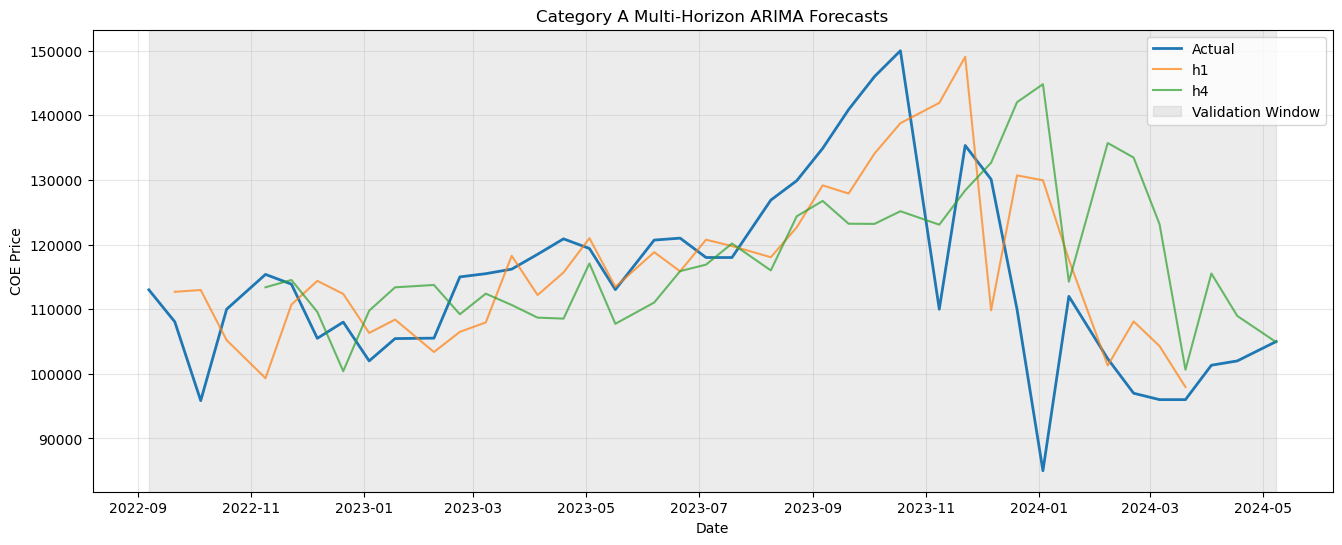

In [44]:
mae_b, aligned_preds_df_b, actual_vals_b, val_dates_b =  rolling_validation_arimax_multihorizon(df_train_b, df_val_b, 'Premium', exog_cols=results_b['selected_features'], order=(0,1,5), max_horizon=4, summary=True)

plot_aligned_forecasts(
    aligned_preds_df_b,
    actual_vals_b,
    0,
    len(actual_vals_b),
    horizons=[1, 4],
    title="Category A Multi-Horizon ARIMA Forecasts"
)

In [67]:
import matplotlib.pyplot as plt

def rolling_validation_with_plot(df, value_col, exog_cols, start_val_date='2022-08-18', end_val_date='2024-05-08', order=(0,1,0), plot=False):
    """
    Perform rolling validation for ARIMA model and optionally plot results.
    """
    # --- ensure sorted by time ---
    df = df.sort_index()
    y_col = value_col

    # --- split train/validation based on years ---
    

    cutoff_train = start_val_date
    cutoff_val = end_val_date

    df_train = df[df.index < cutoff_train]
    df_val = df[(df.index >= cutoff_train) & (df.index <= cutoff_val)]

    # --- print training date range ---
    print(f"Training date range: {df_train.index.min().date()} → {df_train.index.max().date()}")
    print(f"Validation date range: {df_val.index.min().date()} → {df_val.index.max().date()}")

    y_true, y_pred, val_dates = [], [], []

    train_df = df_train.copy()
    full_df = pd.concat([df_train, df_val])

    for t in range(len(df_train), len(full_df) - 1):
        train_data = full_df.iloc[:t]
        test_data = full_df.iloc[t]

        try:
            model = SARIMAX(
                train_data[y_col],
                exog=train_data[exog_cols] if exog_cols else None,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            forecast = model.forecast(
                steps=1,
                exog=test_data[exog_cols].values.reshape(1, -1) if exog_cols else None
            )

            y_pred.append(forecast.iloc[0])
            y_true.append(test_data[y_col])
            val_dates.append(test_data.name)  # capture the timestamp
    
        except Exception as e:
            print(f"Rolling step failed at {test_data.name}: {e}")
            continue

    # --- compute MAE ---
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Validation MAE: {mae:.2f}")

    # --- plot results ---
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(val_dates, y_true, label="Actual", color="black")
        plt.plot(val_dates, y_pred, label="Predicted", color="red", linestyle="--")
        plt.title(f"Rolling Validation Forecast (MAE: {mae:.2f})")
        plt.xlabel("Date")
        plt.ylabel("Target Value")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    return mae, pd.Series(y_true, index=val_dates), pd.Series(y_pred, index=val_dates)




Training date range: 2010-08-18 → 2022-08-17
Validation date range: 2022-09-07 → 2024-05-08
Validation MAE: 3908.08


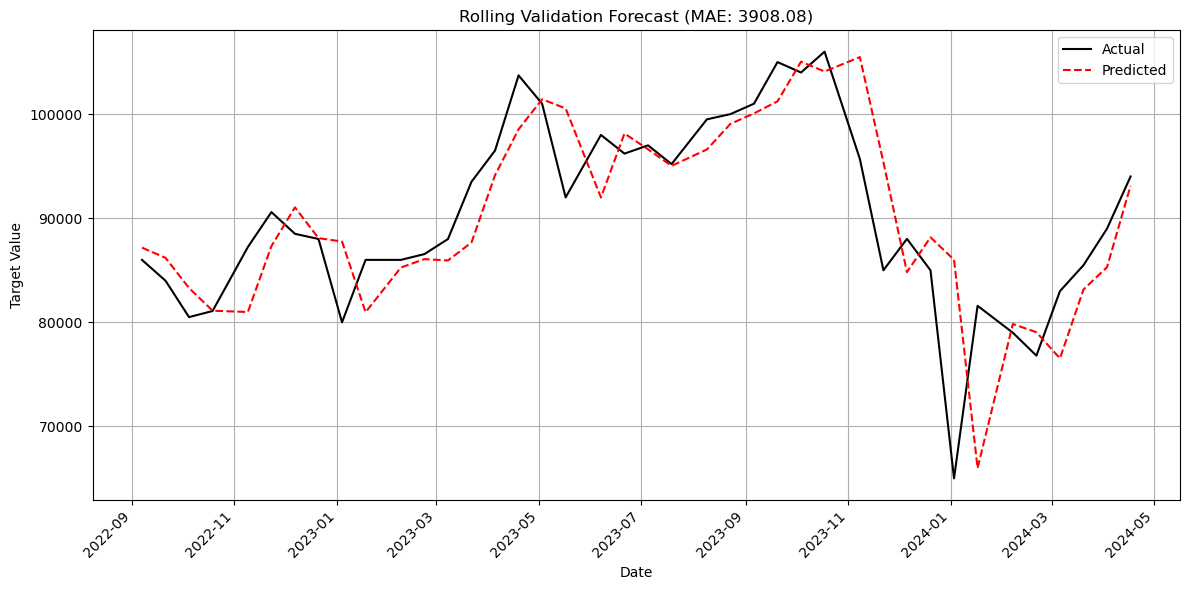

(3908.081065370495,
 2022-09-07     86000.0
 2022-09-21     84000.0
 2022-10-05     80501.0
 2022-10-19     81089.0
 2022-11-09     87235.0
 2022-11-23     90589.0
 2022-12-07     88503.0
 2022-12-21     88007.0
 2023-01-04     80000.0
 2023-01-18     86000.0
 2023-02-08     86000.0
 2023-02-22     86556.0
 2023-03-08     88000.0
 2023-03-22     93503.0
 2023-04-05     96501.0
 2023-04-19    103721.0
 2023-05-03    101001.0
 2023-05-17     92000.0
 2023-06-07     98001.0
 2023-06-21     96206.0
 2023-07-05     97000.0
 2023-07-19     95202.0
 2023-08-09     99499.0
 2023-08-23    100000.0
 2023-09-06    101000.0
 2023-09-20    105000.0
 2023-10-04    104000.0
 2023-10-18    106000.0
 2023-11-08     95689.0
 2023-11-22     85001.0
 2023-12-06     88020.0
 2023-12-20     85000.0
 2024-01-03     65010.0
 2024-01-17     81589.0
 2024-02-07     79000.0
 2024-02-21     76801.0
 2024-03-06     83000.0
 2024-03-20     85489.0
 2024-04-03     89000.0
 2024-04-17     94010.0
 dtype: float64,
 20

In [68]:
rolling_validation_with_plot(df_diff_with_fourier_final_a, value_col='Premium', 
                             exog_cols=results_a['selected_features'],
                                start_val_date='2022-08-18', end_val_date='2024-05-08',
                                order=results_a['best_order'], plot=True)

In [69]:
def longterm_validation_arimax(df, value_col, exog_cols=None, start_val_date='2022-08-18', end_val_date='2024-05-08', order=(1,1,1), plot=True):
    """
    Fit ARIMAX on training data and plot predictions for the validation period only.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with datetime index.
    value_col : str
        Target variable column.
    exog_cols : list, optional
        List of exogenous variable columns.
    train_years : int
        Number of years for training.
    val_years : int
        Number of years for validation.
    order : tuple
        ARIMA order (p,d,q).
    plot : bool
        Whether to plot actual vs predicted for validation.
        
    Returns
    -------
    model : fitted SARIMAX model
    forecast : pd.Series of predicted values for validation
    """
    df = df.sort_index()
    
    # Split training and validation
    cutoff_train = start_val_date
    cutoff_val = end_val_date

    df_train = df[df.index < cutoff_train]
    df_val = df[(df.index >= cutoff_train) & (df.index <= cutoff_val)]

    if len(df_val) == 0:
        raise ValueError("Validation period is empty. Check train_years/val_years.")

    print(f"Training: {df_train.index.min().date()} → {df_train.index.max().date()}, {len(df_train)} records")
    print(f"Validation: {df_val.index.min().date()} → {df_val.index.max().date()}, {len(df_val)} records")

    # Fit ARIMAX on training
    model = SARIMAX(
        df_train[value_col],
        exog=df_train[exog_cols] if exog_cols else None,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Forecast validation period
    if exog_cols:
        forecast = model.forecast(steps=len(df_val), exog=df_val[exog_cols])
    else:
        forecast = model.forecast(steps=len(df_val))

    # Compute MAE
    mae_val = mean_absolute_error(df_val[value_col], forecast)
    print(f"Validation MAE: {mae_val:.2f}")

    # Plot validation period
    if plot:
        plt.figure(figsize=(12,6))
        plt.plot(df_val.index, df_val[value_col], label='Actual', color='black')
        plt.plot(df_val.index, forecast, label='Predicted', color='red', linestyle='--')
        plt.title(f'ARIMAX Forecast on Validation Period (MAE: {mae_val:.2f})')
        plt.xlabel('Date')
        plt.ylabel(f'{value_col} (SGD)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    return model, forecast


    

Training: 2010-08-18 → 2022-08-17, 283 records
Validation: 2022-09-07 → 2024-05-08, 41 records
Validation MAE: 7151.17


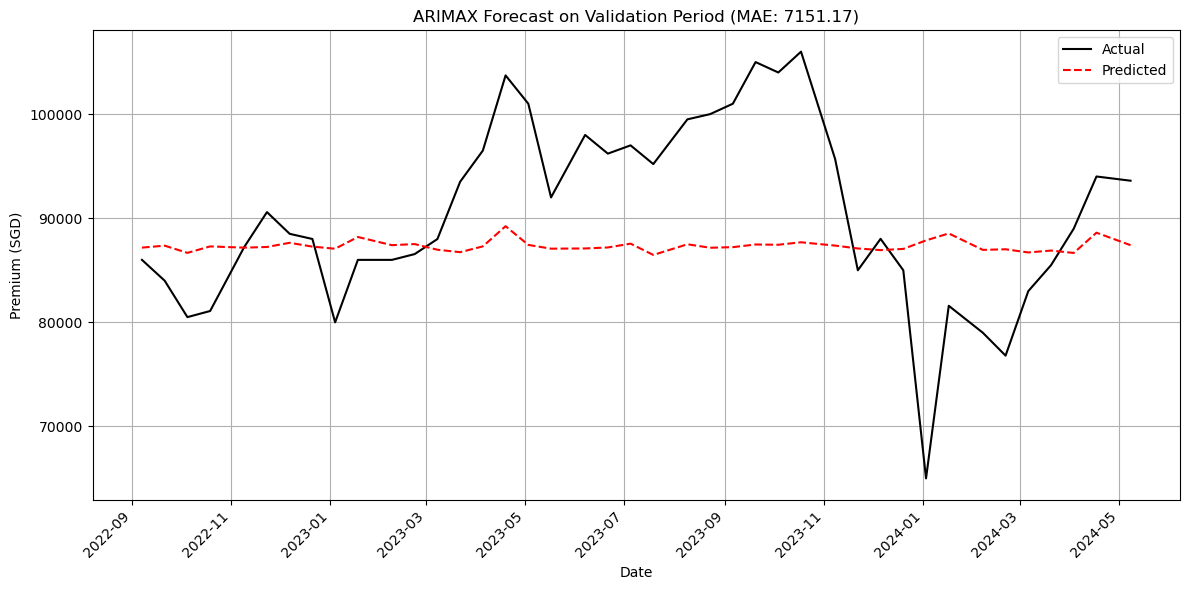

(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x20fb39f4410>,
 283    87177.878122
 284    87365.021919
 285    86672.531391
 286    87292.976299
 287    87173.379528
 288    87238.791889
 289    87640.416520
 290    87273.586428
 291    87069.881765
 292    88198.503359
 293    87412.232542
 294    87517.465754
 295    86974.813940
 296    86739.432832
 297    87296.321450
 298    89235.839110
 299    87437.992169
 300    87076.481056
 301    87096.731015
 302    87192.097880
 303    87559.241363
 304    86474.483412
 305    87497.390789
 306    87165.956813
 307    87221.599586
 308    87477.076020
 309    87452.585294
 310    87690.450165
 311    87372.027248
 312    87095.646513
 313    86935.852639
 314    87053.411252
 315    87871.367117
 316    88539.369537
 317    86960.306283
 318    87017.981546
 319    86713.352233
 320    86894.631082
 321    86665.174134
 322    88611.008058
 323    87410.695491
 Name: predicted_mean, dtype: float64)

In [70]:
longterm_validation_arimax(df_diff_with_fourier_final_a, value_col='Premium', 
                             exog_cols=results_a['selected_features'],
                               start_val_date='2022-08-18', end_val_date='2024-05-08',
                                order=results_a['best_order'], plot=True)

In [ ]:
results_b = forward_select_arimax(df_diff_with_fourier_final_b, filter_b, ['Premium'], start_val_date='2022-08-18', end_val_date='2024-05-08')
results_b

Training date range: 2010-08-18 → 2022-08-17, 181 records
Validation date range: 2022-09-07 → 2024-05-08, 28 records

=== Iteration 1 ===


Evaluating candidate features:   0%|          | 0/40 [00:00<?, ?it/s]

181 181


Evaluating candidate features:   2%|▎         | 1/40 [00:01<00:39,  1.02s/it]

181 181


Evaluating candidate features:   5%|▌         | 2/40 [00:02<00:53,  1.40s/it]

181 181


Evaluating candidate features:   8%|▊         | 3/40 [00:03<00:48,  1.31s/it]

181 181


Evaluating candidate features:  10%|█         | 4/40 [00:05<00:50,  1.41s/it]

181 181


Evaluating candidate features:  10%|█         | 4/40 [00:06<00:55,  1.55s/it]


KeyboardInterrupt: 

In [ ]:
rolling_validation_with_plot(df_diff_with_fourier_final_b, value_col='Premium', 
                             exog_cols=results_b['selected_features'],
                                start_val_date='2022-08-18', end_val_date='2024-05-08',
                                order=results_b['best_order'], plot=True)
longterm_validation_arimax(df_diff_with_fourier_final_b, value_col='Premium', 
                             exog_cols=results_b['selected_features'],
                                start_val_date='2022-08-18', end_val_date='2024-05-08',
                                order=results_b['best_order'], plot=True)

{'selected_features': ['Bids_Success_Frac_lag1_diff_12',
  'Close_prev_day_diff_2',
  'Wholesale & Retail Trade_lag3_diff_2',
  'Transportation & Storage_lag3_diff_9',
  'Close_prev_day_diff_1',
  'sin_1',
  'Close_prev_day_diff_9',
  'Bids_Received_lag1_diff_1',
  'Close_prev_day_diff_10',
  'Bids_Success_Frac_lag1_diff_11'],
 'best_order': (0, 1, 0),
 'best_mae': 5141.147069648851}

In [56]:
print(results_b)

{'selected_features': ['Bids_Success_Frac_lag1_diff_5', 'cos_1', 'Close_prev_day_diff_1', 'Wholesale & Retail Trade_lag3_diff_2', 'Bids_Received_lag1_diff_5', 'Bids_Success_Frac_lag1_diff_12', 'Close_prev_day_diff_2', 'Quota_lag1_diff_4', 'sin_1', 'Close_prev_day_diff_10', 'Bids_Received_lag1_diff_1', 'Bids_Success_lag1_diff_4', 'Transportation & Storage_lag3_diff_9', 'Bids_Success_Frac_lag1_diff_11', 'Bids_Success_Frac_lag1_diff_2', 'Close_prev_day_diff_9', 'Bids_Received_lag1_diff_3'], 'best_order': (1, 1, 1), 'best_mae': 3493.1471806571376}


results_a = {'selected_features': ['Close_prev_day_diff_3', 'Wholesale & Retail Trade_lag3_diff_2', 'Wholesale & Retail Trade_lag3_diff_10', 'cos_1', 'Finance & Insurance_lag3_diff_1', 'Close_prev_day_diff_11', 'Bids_Success_Frac_lag1_diff_10', 'Close_prev_day_diff_9', 'Finance & Insurance_lag3_diff_2', 'sin_1', 'Wholesale & Retail Trade_lag3_diff_11', 'Bids_Received_lag1_diff_7', 'Manufacturing_lag3_diff_3', 'Close_prev_day_diff_2', 'Bids_Received_lag1_diff_4', 'Quota_lag1_diff_4'], 'best_order': (0, 1, 0), 'best_mae': 2992.857373101204}

results_b = {'selected_features': ['Bids_Success_Frac_lag1_diff_5', 'cos_1', 'Close_prev_day_diff_1', 'Wholesale & Retail Trade_lag3_diff_2', 'Bids_Received_lag1_diff_5', 'Bids_Success_Frac_lag1_diff_12', 'Close_prev_day_diff_2', 'Quota_lag1_diff_4', 'sin_1', 'Close_prev_day_diff_10', 'Bids_Received_lag1_diff_1', 'Bids_Success_lag1_diff_4', 'Transportation & Storage_lag3_diff_9', 'Bids_Success_Frac_lag1_diff_11', 'Bids_Success_Frac_lag1_diff_2', 'Close_prev_day_diff_9', 'Bids_Received_lag1_diff_3'], 'best_order': (1, 1, 1), 'best_mae': 3493.1471806571376}